In [1]:
%load_ext autoreload
%autoreload 2

# Quantum Devices benchmarking

In [2]:
python_script = "../../z2chain/benchmark.py"
stdout_path = "../../z2chain/benchmark.log"
stderr_path = "../../z2chain/benchmark.err"
database_path = "../../z2chain/benchmarkdb.json"
simulator_folder_path = "Benchmark simulations/"
benchmark_plot_filepath = "benchmark.png"

## Launctl status

In [5]:
from utils.benchmarking import check_benchmark_status_mac

check_benchmark_status_mac(stdout_path)

The benchmark is NOT running


## Benchmark settings

In [4]:
from dateutil.relativedelta import relativedelta
from utils.benchmarking import create_estimator_options

J = 1
h = 0.05
lamb = 0.7
t_compute = 1.6
x_basis = False

L_arr = [40]
layers_arr = [5]
backends_arr = ["ibm_fez", "ibm_torino", "ibm_kyiv", "ibm_sherbrooke", "ibm_brussels"]

shots = [4096]
optimization_levels = [0]
zne_extrapolator_noise_levels = [None, ("linear", [1, 1.2, 1.5]), ("polynomial_degree_2", [1, 1.2, 1.5]), ("exponential", [1, 1.2, 1.5])]
measure_mitigations = [True]
dd_sequences = ["XY4"]
twirlings = [True]
estimator_options_dicts = create_estimator_options(shots, optimization_levels, zne_extrapolator_noise_levels, measure_mitigations, dd_sequences, twirlings)

seconds_to_start_interval = 21600
start_relativedeltas = [relativedelta(hour=0, minute=0), relativedelta(hour=4, minute=0), relativedelta(hour=8, minute=0), relativedelta(hour=12, minute=0), relativedelta(hour=16, minute=0), relativedelta(hour=20, minute=0)]

### Run benchmark

In [5]:
from utils.benchmarking import generate_and_execute_launchctl_file_mac
from cobos.tokens import ibm_token, group_instance
import json

args = [
    database_path,
    ibm_token,
    "-i", group_instance,
    "-n", *L_arr,
    "-d", *layers_arr,
    "-b", *backends_arr,
    "-t", t_compute,
    "-j", J,
    "-g", h,
    "-l", lamb,
    "-o", json.dumps(estimator_options_dicts),
]

if x_basis: args.append("-x")

args = [str(arg) for arg in args]

generate_and_execute_launchctl_file_mac(
    python_script,
    *args,
    seconds_start_interval=seconds_to_start_interval,
    start_relativedeltas=start_relativedeltas,
    stdout_path=stdout_path,
    stderr_path=stderr_path,
)

### Stop benchmark

In [4]:
from utils.benchmarking import stop_benchmark_mac

stop_benchmark_mac()

## Database utilities

### Update database

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from cobos.tokens import ibm_token, group_instance
from utils.benchmarking import BenchmarkDB

benchmarkdb = BenchmarkDB(database_path)

service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token, instance=group_instance)
benchmarkdb.update_status(service, print_mode=True)

## Plot

### Date selection

In [5]:
from ipywidgets import DatetimePicker
import datetime

start_time_dtpicker = DatetimePicker(description="Start time", value=datetime.datetime.now().astimezone(datetime.timezone.utc)-datetime.timedelta(days=15))
final_time_dtpicker = DatetimePicker(description="Final time", value=datetime.datetime.now().astimezone(datetime.timezone.utc))
display(start_time_dtpicker, final_time_dtpicker)

DatetimePicker(value=datetime.datetime(2024, 8, 27, 7, 27, 45, 846227, tzinfo=datetime.timezone.utc), descript…

DatetimePicker(value=datetime.datetime(2024, 9, 11, 7, 27, 45, 847119, tzinfo=datetime.timezone.utc), descript…

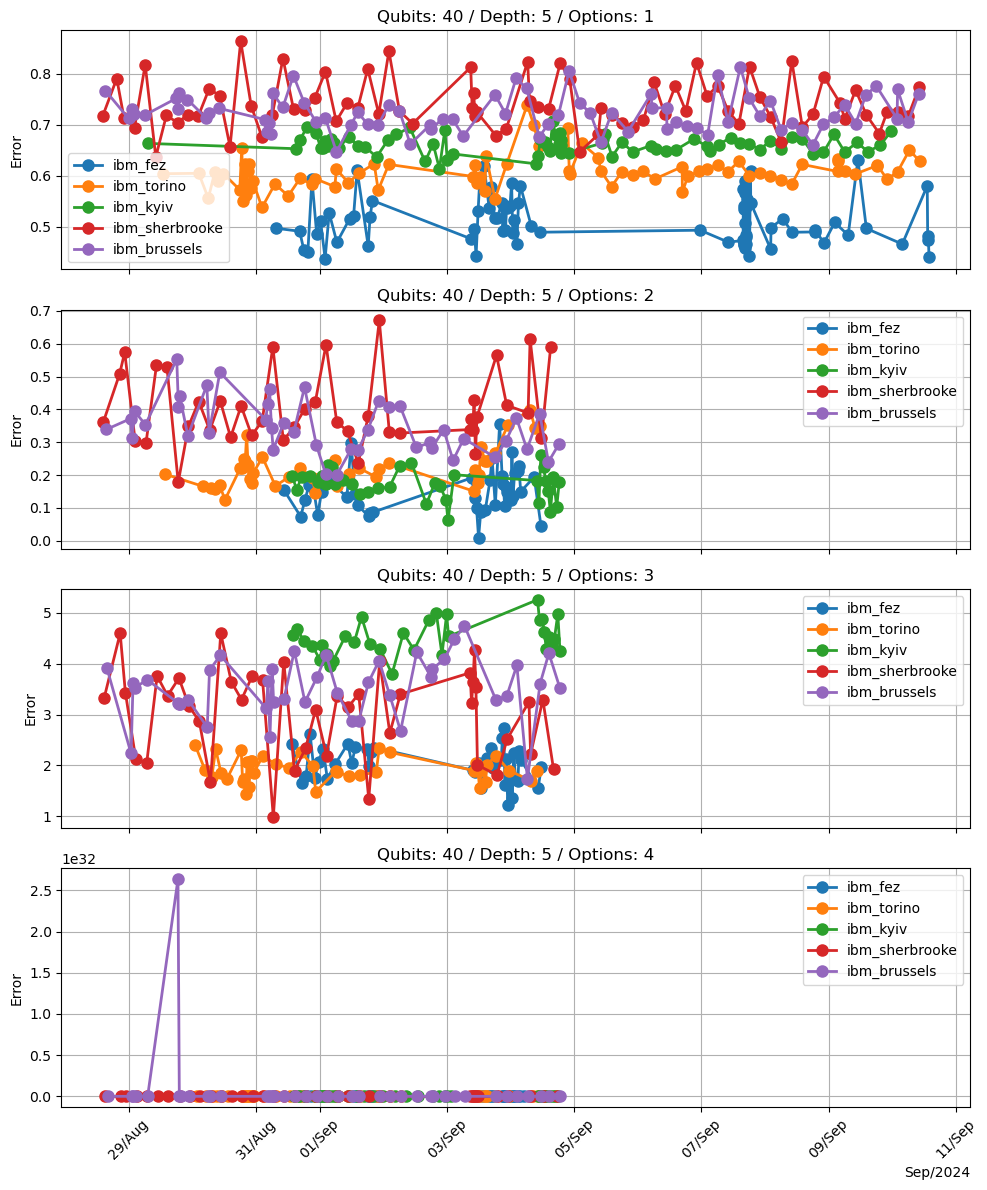

In [6]:
from z2chain.operators import pauli_zs_mean, pauli_xs_mean
from z2chain.benchmark import get_z2_chain_benchmark_circuit
from utils.benchmarking import BenchmarkDB
from datetime import timezone

z2_chain_benchmark_circuit_func = lambda chain_length, layers: get_z2_chain_benchmark_circuit(chain_length, J, h, lamb, t_compute, layers, x_basis)
logical_observable_func = pauli_xs_mean if x_basis else pauli_zs_mean
test_circuit_name = "z2_chain_trotter_compuncomp"
observable_name = "mean_paulis_" + ("x" if x_basis else "z")

date_range = [min(start_time_dtpicker.value, final_time_dtpicker.value).astimezone(timezone.utc), max(start_time_dtpicker.value, final_time_dtpicker.value).astimezone(timezone.utc)]

benchmarkdb = BenchmarkDB(database_path)
benchmarkdb.plot_mean_error_by_date(L_arr, layers_arr, backends_arr, estimator_options_dicts, z2_chain_benchmark_circuit_func, logical_observable_func, test_circuit_name, observable_name, date_range, plot_filepath=benchmark_plot_filepath, print_mode=True)